# Model - Convolutional Neural Network

In the case of the CNN classifier, we applied word-embedding procedures
from the pre-processed texts using the word2vec API of Python Package, Gensim. The word vectors were pretrained
with the training dataset collected for the current study with continuous bag-of-words representation
(CBOW) models, while the size of window was set to five. Note that by using the pre-trained word2vec model
for representing each post for each subreddit, a language style used by users who write posts in a subreddit can
be trained for the specific subreddit.

##### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Flatten, Dense, Embedding
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

##### Load data

In [2]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

In [3]:
posts.head(1)

,author,created_utc,subreddit,timeframe,text_clean,sent_tokens,word_tokens
0,sub30605,1499390694,bulimia,pre-covid,chest anyone else experience chest purging kno...,['chest anyone else experience chest purging k...,"['chest', 'anyone', 'else', 'experience', 'che..."


##### Binarize targets using get_dummies

Will use each subreddit as target (except mental health)

In [4]:
posts = pd.get_dummies(posts, columns=['subreddit'])

In [5]:
posts.drop(columns='subreddit_mentalhealth', inplace = True)

### Tokenizing the raw text

We will vectorize the text and prepare a training and validation split

In [6]:
texts = posts['text_clean']

In [7]:
maxlen = 1000 # Cuts off posts after 1000 words
max_words = 5000 # Considers the top specified number of words in the dataset

In [8]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

In [9]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [10]:
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=maxlen)

### Parcing the word2vec embeddings File

We will use our previously created word2vec embeddings

#### Parsing the word-embeddings files

In [11]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [12]:
embedding_dim = 50 # Come back to this, still don't really understand how embedding dimensions affect things

embedding_matrix = create_embedding_matrix('../embedding_word2vec.txt',
                                           tokenizer.word_index, embedding_dim)

In [13]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7723224480474994

This means about 77% of the vocabulary is covered by the pre-trained model... that doesn't seem great.. maybe we can achieve better coverage by tweaking our word2vec model in the previous notebook. 

# Subreddit: Anxiety

In [14]:
labels = posts['subreddit_Anxiety']

In [15]:
labels = np.asarray(labels)
print('Shape of data:', data.shape)
print('Shape of label:', labels.shape)

Shape of data: (84879, 1000)
Shape of label: (84879,)


#### Train test split

In [16]:
X = data
y = labels

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [18]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [19]:
counter = Counter(y_train)
print(counter)

Counter({0: 60349, 1: 7554})


Above we see the extent to which our classes are imbalanced, our "non-anxiety" class has 50,349 observations and our "anxiety" class has 7544 observations.

In [20]:
model1 = Sequential()
model1.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model1.add(layers.GlobalMaxPool1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(Dropout(0.25))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [21]:
history = model1.fit(X_train, y_train,
                    epochs=14, # employ early stopping at around 13 epochs # was 89% acc. at 50 epochs
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64) # number of samples before updating the internal model parameters
loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8888
Testing Accuracy:  0.8888


### Define function to plot the accuracy scores

In [23]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Plot accuracy scores and loss values

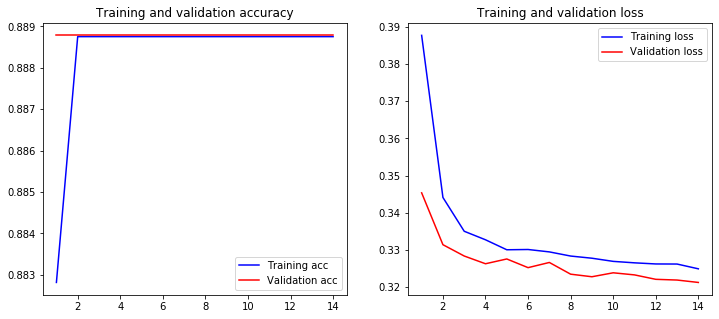

In [24]:
plot_history(history)
plt.savefig('../images/anxiety_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [25]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60349, 1: 60349})


As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

In [26]:
model1_sm = Sequential()
model1_sm.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model1_sm.add(layers.GlobalMaxPool1D())
model1_sm.add(layers.Dense(10, activation='relu'))
model1_sm.add(Dropout(0.25))
model1_sm.add(layers.Dense(1, activation='sigmoid'))
model1_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1_sm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [27]:
history = model1_sm.fit(X_train_sm, y_train_sm,
                    epochs=20, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64) # number of samples before updating the internal model parameters
loss, accuracy = model1_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
1886/1886 [==============================] - 7s 3ms/step - loss: 0.7154 - accuracy: 0.5523 - val_loss: 0.6740 - val_accuracy: 0.4533
Epoch 2/20
1886/1886 [==============================] - 7s 3ms/step - loss: 0.6611 - accuracy: 0.6041 - val_loss: 0.6217 - val_accuracy: 0.5877
Epoch 3/20
1886/1886 [==============================] - 7s 4ms/step - loss: 0.6479 - accuracy: 0.6213 - val_loss: 0.6630 - val_accuracy: 0.5379
Epoch 4/20
1886/1886 [==============================] - 7s 3ms/step - loss: 0.6394 - accuracy: 0.6313 - val_loss: 0.6297 - val_accuracy: 0.5799
Epoch 5/20
1886/1886 [==============================] - 7s 4ms/step - loss: 0.6334 - accuracy: 0.6391 - val_loss: 0.6542 - val_accuracy: 0.5607
Epoch 6/20
1886/1886 [==============================] - 8s 4ms/step - loss: 0.6329 - accuracy: 0.6411 - val_loss: 0.6273 - val_accuracy: 0.6110
Epoch 7/20
1886/1886 [==============================] - 8s 4ms/step - loss: 0.6303 - accuracy: 0.6440 - val_loss: 0.6199 - val_accuracy:

### Plot accuracy scores and loss values

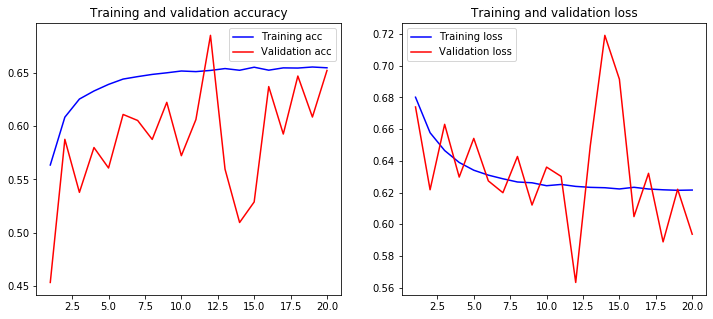

In [28]:
plot_history(history)
plt.savefig('../images/anxiety_cnn_smote.png');

# Subreddit: Anorexia Nervosa

In [29]:
labels = posts['subreddit_AnorexiaNervosa']

#### Train test split

In [30]:
X = data
y = labels

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [32]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [33]:
counter = Counter(y_train)
print(counter)

Counter({0: 60170, 1: 7733})


Above we see the extent to which our classes are imbalanced, our "non-anorexia nervosa" class has 60,170 observations and our "anorexia nervosa" class has 7733 observations.

In [48]:
model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model2.add(layers.GlobalMaxPool1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(Dropout(0.25))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [49]:
history = model2.fit(X_train, y_train,
                    epochs=20, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
1061/1061 [==============================] - 4s 3ms/step - loss: 0.3980 - accuracy: 0.8785 - val_loss: 0.3032 - val_accuracy: 0.8861
Epoch 2/20
1061/1061 [==============================] - 4s 3ms/step - loss: 0.3085 - accuracy: 0.8883 - val_loss: 0.2856 - val_accuracy: 0.8861
Epoch 3/20
1061/1061 [==============================] - 4s 3ms/step - loss: 0.2967 - accuracy: 0.8846 - val_loss: 0.2784 - val_accuracy: 0.8861
Epoch 4/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.2924 - accuracy: 0.8864 - val_loss: 0.2747 - val_accuracy: 0.8861
Epoch 5/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.2909 - accuracy: 0.8850 - val_loss: 0.2733 - val_accuracy: 0.8861
Epoch 6/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.2837 - accuracy: 0.8875 - val_loss: 0.2718 - val_accuracy: 0.8862
Epoch 7/20
1061/1061 [==============================] - 4s 3ms/step - loss: 0.2884 - accuracy: 0.8845 - val_loss: 0.2734 - val_accuracy:

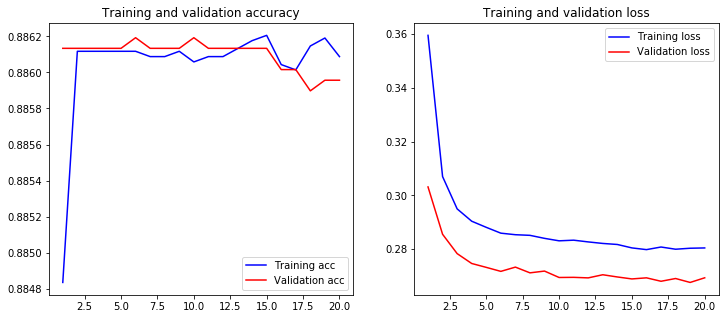

In [50]:
plot_history(history)
plt.savefig('../images/anorexia_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [51]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60170, 1: 60170})


As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [52]:
model2_sm = Sequential()
model2_sm.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model2_sm.add(layers.GlobalMaxPool1D())
model2_sm.add(layers.Dense(10, activation='relu'))
model2_sm.add(Dropout(0.25))
model2_sm.add(layers.Dense(1, activation='sigmoid'))
model2_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2_sm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [53]:
history = model2_sm.fit(X_train_sm, y_train_sm,
                    epochs=20, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model2_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
1881/1881 [==============================] - 6s 3ms/step - loss: 0.7173 - accuracy: 0.5456 - val_loss: 0.5788 - val_accuracy: 0.7762
Epoch 2/20
1881/1881 [==============================] - 6s 3ms/step - loss: 0.6531 - accuracy: 0.6101 - val_loss: 0.6463 - val_accuracy: 0.6415
Epoch 3/20
1881/1881 [==============================] - 6s 3ms/step - loss: 0.6440 - accuracy: 0.6257 - val_loss: 0.5929 - val_accuracy: 0.7169
Epoch 4/20
1881/1881 [==============================] - 6s 3ms/step - loss: 0.6388 - accuracy: 0.6318 - val_loss: 0.6117 - val_accuracy: 0.6666
Epoch 5/20
1881/1881 [==============================] - 6s 3ms/step - loss: 0.6354 - accuracy: 0.6370 - val_loss: 0.6181 - val_accuracy: 0.6595
Epoch 6/20
1881/1881 [==============================] - 6s 3ms/step - loss: 0.6320 - accuracy: 0.6413 - val_loss: 0.5762 - val_accuracy: 0.7230
Epoch 7/20
1881/1881 [==============================] - 7s 4ms/step - loss: 0.6291 - accuracy: 0.6455 - val_loss: 0.6152 - val_accuracy:

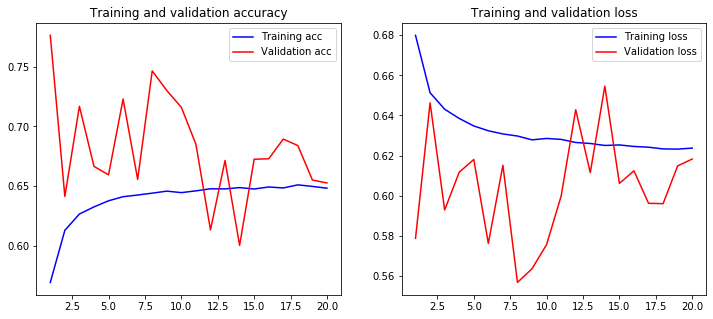

In [54]:
plot_history(history)
plt.savefig('../images/anorexia_cnn_smote.png');

# Subreddit: Bulimia

In [55]:
labels = posts['subreddit_bulimia']

#### Train test split

In [56]:
X = data
y = labels

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [58]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [59]:
counter = Counter(y_train)
print(counter)

Counter({0: 60106, 1: 7797})


Above we see the extent to which our classes are imbalanced, our "non-bulimia" class has 60,106 observations and our "bulimia" class has 7797 observations.

In [60]:
model3 = Sequential()
model3.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model3.add(layers.GlobalMaxPool1D())
model3.add(layers.Dense(10, activation='relu'))
model3.add(Dropout(0.25))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [61]:
history = model3.fit(X_train, y_train,
                    epochs= 20, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
1061/1061 [==============================] - 5s 4ms/step - loss: 0.5112 - accuracy: 0.8323 - val_loss: 0.3180 - val_accuracy: 0.8851
Epoch 2/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3364 - accuracy: 0.8841 - val_loss: 0.2998 - val_accuracy: 0.8851
Epoch 3/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3167 - accuracy: 0.8846 - val_loss: 0.2947 - val_accuracy: 0.8850
Epoch 4/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3090 - accuracy: 0.8840 - val_loss: 0.2989 - val_accuracy: 0.8852
Epoch 5/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3037 - accuracy: 0.8841 - val_loss: 0.2942 - val_accuracy: 0.8850
Epoch 6/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3002 - accuracy: 0.8852 - val_loss: 0.2909 - val_accuracy: 0.8851
Epoch 7/20
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3006 - accuracy: 0.8842 - val_loss: 0.2889 - val_accuracy:

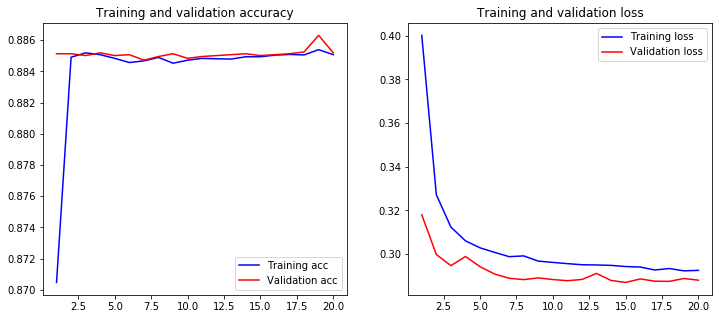

In [62]:
plot_history(history)
plt.savefig('../images/bulimia_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [63]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60106, 1: 60106})


As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [64]:
model3_sm = Sequential()
model3_sm.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model3_sm.add(layers.GlobalMaxPool1D())
model3_sm.add(layers.Dense(10, activation='relu'))
model3_sm.add(Dropout(0.25))
model3_sm.add(layers.Dense(1, activation='sigmoid'))
model3_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3_sm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [65]:
history = model3_sm.fit(X_train_sm, y_train_sm,
                    epochs=20, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model3_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
1879/1879 [==============================] - 7s 3ms/step - loss: 0.6914 - accuracy: 0.5460 - val_loss: 0.6586 - val_accuracy: 0.5431
Epoch 2/20
1879/1879 [==============================] - 6s 3ms/step - loss: 0.6634 - accuracy: 0.5994 - val_loss: 0.6468 - val_accuracy: 0.5720
Epoch 3/20
1879/1879 [==============================] - 7s 3ms/step - loss: 0.6524 - accuracy: 0.6171 - val_loss: 0.6460 - val_accuracy: 0.5751
Epoch 4/20
1879/1879 [==============================] - 6s 3ms/step - loss: 0.6473 - accuracy: 0.6262 - val_loss: 0.6656 - val_accuracy: 0.5507
Epoch 5/20
1879/1879 [==============================] - 6s 3ms/step - loss: 0.6418 - accuracy: 0.6336 - val_loss: 0.5796 - val_accuracy: 0.6951
Epoch 6/20
1879/1879 [==============================] - 7s 4ms/step - loss: 0.6421 - accuracy: 0.6325 - val_loss: 0.6285 - val_accuracy: 0.6186
Epoch 7/20
1879/1879 [==============================] - 6s 3ms/step - loss: 0.6405 - accuracy: 0.6332 - val_loss: 0.5719 - val_accuracy:

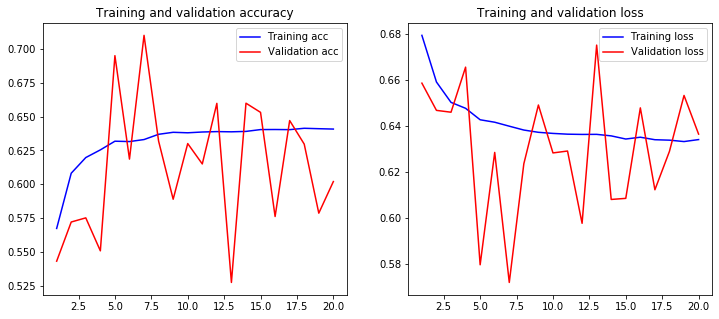

In [66]:
plot_history(history)
plt.savefig('../images/bulimia_cnn_smote.png');

# Subreddit: Schizophrenia

In [67]:
labels = posts['subreddit_schizophrenia']

#### Train test split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size = .2,
                                                    random_state=42)

In [69]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with imbalanced classes

In [70]:
counter = Counter(y_train)
print(counter)

Counter({0: 60303, 1: 7600})


In [71]:
model4 = Sequential()
model4.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model4.add(layers.GlobalMaxPool1D())
model4.add(layers.Dense(10, activation='relu'))
model4.add(Dropout(0.25))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [72]:
history = model4.fit(X_train, y_train,
                    epochs= 30, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=65)
loss, accuracy = model4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/30
1045/1045 [==============================] - 4s 4ms/step - loss: 0.4184 - accuracy: 0.8697 - val_loss: 0.3275 - val_accuracy: 0.8937
Epoch 2/30
1045/1045 [==============================] - 4s 4ms/step - loss: 0.3522 - accuracy: 0.8872 - val_loss: 0.3231 - val_accuracy: 0.8937
Epoch 3/30
1045/1045 [==============================] - 4s 4ms/step - loss: 0.3440 - accuracy: 0.8873 - val_loss: 0.3224 - val_accuracy: 0.8937
Epoch 4/30
1045/1045 [==============================] - 4s 4ms/step - loss: 0.3373 - accuracy: 0.8885 - val_loss: 0.3196 - val_accuracy: 0.8937
Epoch 5/30
1045/1045 [==============================] - 4s 4ms/step - loss: 0.3345 - accuracy: 0.8887 - val_loss: 0.3188 - val_accuracy: 0.8937
Epoch 6/30
1045/1045 [==============================] - 4s 4ms/step - loss: 0.3344 - accuracy: 0.8875 - val_loss: 0.3191 - val_accuracy: 0.8939
Epoch 7/30
1045/1045 [==============================] - 4s 4ms/step - loss: 0.3291 - accuracy: 0.8895 - val_loss: 0.3178 - val_accuracy:

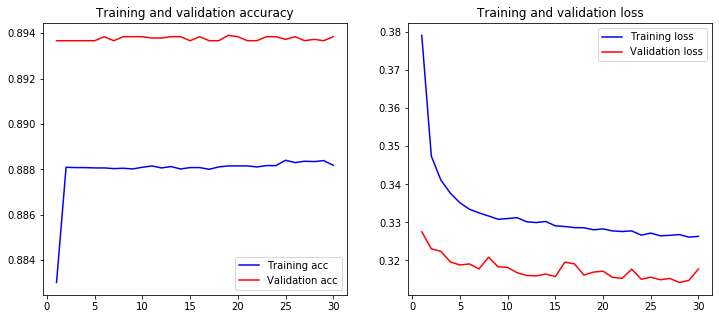

In [73]:
plot_history(history)
plt.savefig('../images/schiz_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [74]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60303, 1: 60303})


As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [75]:
model4_sm = Sequential()
model4_sm.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model4_sm.add(layers.GlobalMaxPool1D())
model4_sm.add(layers.Dense(10, activation='relu'))
model4_sm.add(Dropout(0.25))
model4_sm.add(layers.Dense(1, activation='sigmoid'))
model4_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model4_sm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1000, 50)          1094750   
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 1,095,271
Trainable params: 521
Non-trainable params: 1,094,750
_________________________________________________________________


In [76]:
history = model4_sm.fit(X_train_sm, y_train_sm,
                    epochs=20, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model4_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
1885/1885 [==============================] - 6s 3ms/step - loss: 0.7079 - accuracy: 0.5197 - val_loss: 0.7257 - val_accuracy: 0.3837
Epoch 2/20
1885/1885 [==============================] - 6s 3ms/step - loss: 0.6847 - accuracy: 0.5448 - val_loss: 0.6685 - val_accuracy: 0.6120
Epoch 3/20
1885/1885 [==============================] - 6s 3ms/step - loss: 0.6794 - accuracy: 0.5566 - val_loss: 0.6521 - val_accuracy: 0.6430
Epoch 4/20
1885/1885 [==============================] - 6s 3ms/step - loss: 0.6755 - accuracy: 0.5658 - val_loss: 0.6943 - val_accuracy: 0.5083
Epoch 5/20
1885/1885 [==============================] - 6s 3ms/step - loss: 0.6717 - accuracy: 0.5730 - val_loss: 0.6150 - val_accuracy: 0.7114
Epoch 6/20
1885/1885 [==============================] - 6s 3ms/step - loss: 0.6686 - accuracy: 0.5778 - val_loss: 0.6629 - val_accuracy: 0.5864
Epoch 7/20
1885/1885 [==============================] - 6s 3ms/step - loss: 0.6657 - accuracy: 0.5813 - val_loss: 0.6633 - val_accuracy:

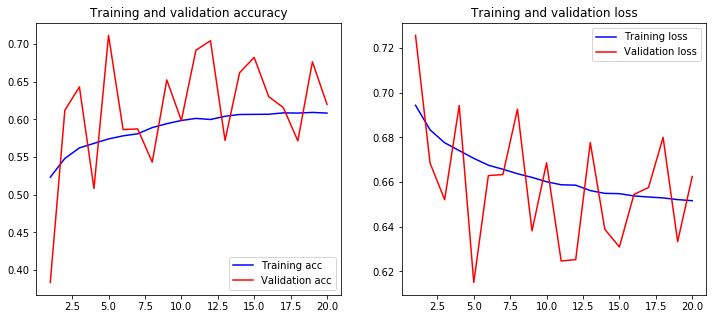

In [77]:
plot_history(history)
plt.savefig('../images/schiz_cnn_smote.png');